In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip CNN.zip

Archive:  CNN.zip
   creating: CNN/
   creating: CNN/variables/
  inflating: CNN/variables/variables.data-00000-of-00001  
  inflating: CNN/variables/variables.index  
  inflating: CNN/saved_model.pb      
 extracting: CNN/fingerprint.pb      
  inflating: CNN/keras_metadata.pb   
   creating: CNN/assets/


In [ ]:
import tensorflow as tf
tf.random.set_seed(10)
import random
random.seed()

import os
import sys
import numpy as np

from keras import layers

from tensorflow.python.keras.backend import clear_session

from keras.layers import Input, Convolution2D, Convolution1D, MaxPooling2D, Dense, Dropout, \
                          Flatten, concatenate, Activation, Reshape, \
                          UpSampling2D,ZeroPadding2D
from keras.layers import Dense
from keras import Sequential
import h5py
import keras

from scipy.io import loadmat,savemat


#train_orig = 2000

#percent = 10

#trainN = int(int(percent)*.01*train_orig)
trainN = 160

valN=41
lead=1;
batch_size = 16
num_epochs = 50
pool_size = 2
drop_prob=0.0
conv_activation='relu'
Nlat=64
Nlon=64
n_channels=3
#NT = 3000 # Numer of snapshots per file
numDataset = 1 # number of dataset / 2

## Data set has 100k data points


print('Start....')


def reset_keras():
    sess = tf.compat.v1.keras.backend.get_session()
    tf.compat.v1.keras.backend.clear_session()
    sess.close()
    sess = tf.compat.v1.keras.backend.get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

def build_model(conv_depth, kernel_size, hidden_size, n_hidden_layers, lr):

    model = keras.Sequential([

            ## Convolution with dimensionality reduction (similar to Encoder in an autoencoder)
            Convolution2D(conv_depth, kernel_size, padding='same', activation=conv_activation, input_shape=(Nlon,Nlat,n_channels),trainable = False),
            Convolution2D(conv_depth, kernel_size, padding='same', activation=conv_activation,trainable = False),
            Convolution2D(conv_depth, kernel_size, padding='same', activation=conv_activation,trainable = False),
            Convolution2D(conv_depth, kernel_size, padding='same', activation=conv_activation,trainable = False),
            Convolution2D(conv_depth, kernel_size, padding='same', activation=conv_activation,trainable = False),

            ] + [keras.layers.Dense(hidden_size, activation='sigmoid', trainable = False) for i in range(n_hidden_layers)] +

            [

            Convolution2D(conv_depth, kernel_size, padding='same', activation=conv_activation,trainable = False),
            Convolution2D(conv_depth, kernel_size, padding='same', activation=conv_activation,trainable = False),
            Convolution2D(conv_depth, kernel_size, padding='same', activation=conv_activation,trainable = False),
            Convolution2D(conv_depth, kernel_size, padding='same', activation=conv_activation,trainable = False),
            Convolution2D(conv_depth, kernel_size, padding='same', activation=conv_activation,trainable = False),
            layers.Convolution2D(5, kernel_size, padding='same', activation=None,trainable = False)
            ]
            )
    optimizer= keras.optimizers.Adam(lr=lr)


    model.compile(loss='mean_squared_error', optimizer = optimizer)

    return model

Start....


In [ ]:
import h5py
import numpy as np

# Load the files which contain the simulation data for the target system (Ra = 10^6)

filename = "/content/drive/MyDrive/mtp2/TL_data_new/input_normalized.h5"

with h5py.File(filename, "r") as f:
  input_normalized = np.array(f['input_normalized'])
  print(input_normalized.shape)

filename = "/content/drive/MyDrive/mtp2/TL_data_new/input_normalized_val.h5"

with h5py.File(filename, "r") as f:
  input_normalized_val = np.array(f['input_normalized_val'])
  print(input_normalized_val.shape)

filename = "/content/drive/MyDrive/mtp2/TL_data_new/output_normalized.h5"

with h5py.File(filename, "r") as f:
  output_normalized = np.array(f['output_normalized'])
  print(output_normalized.shape)

filename = "/content/drive/MyDrive/mtp2/TL_data_new/output_normalized_val.h5"

with h5py.File(filename, "r") as f:
  output_normalized_val = np.array(f['output_normalized_val'])
  print(output_normalized_val.shape)

(160, 64, 64, 3)
(41, 64, 64, 3)
(160, 64, 64, 5)
(41, 64, 64, 5)


In [ ]:
params = {'conv_depth': 32, 'hidden_size': 5000,
              'kernel_size': 5, 'lr': 0.00005, 'n_hidden_layers': 0}


for j in range(1,12):
    TL_layers = str(j)
    layers_str = '_' + TL_layers


    print('Finish Initialization')
    print(np.shape(input_normalized))
    print('Memory taken by training input:')
    print(input_normalized.nbytes)
    print('Memory taken by training output:')
    print(np.shape(output_normalized))
    print(output_normalized.nbytes)

    print('Memory taken by validation input:')
    print(input_normalized_val.nbytes)
    print('Memory taken by validation output:')
    print(np.shape(output_normalized))
    print(output_normalized_val.nbytes)


    reset_keras()

    model = build_model(**params)

    model.load_weights('CNN')


    layer = model.layers[j-1]
    layer.trainable = True

    print(model.summary())
    optimizer= keras.optimizers.Adam(lr=params['lr'])

    model.compile(loss='mean_squared_error', optimizer = optimizer)

    loss = []
    val_loss = []

    hist = model.fit(input_normalized[0:trainN,:,:,:], output_normalized[0:trainN,:,:,:],
                 batch_size = batch_size,shuffle='True',
                 verbose = 0,
                 epochs = num_epochs,
                 validation_data=(input_normalized_val[:,:,:,:],output_normalized_val[:,:,:,:]))

    loss = np.hstack([loss,hist.history['loss']])
    val_loss = np.hstack([val_loss,hist.history['val_loss']])
    print(val_loss)


    savemat('./Loss_TL_from_Ra_10k_to_Re_1M_per_train_p' + '_layers'+str(layers_str) + '.mat',dict([('loss',loss),('val_loss',val_loss)]))
    model.save_weights('./weights_TL_from_Ra_10k_to_Re_1M_per_train_p'+'_layers'+str(layers_str))
    model.save('./Models/CNN_TL_from_Ra_10k_to_Re_1M_per_train_p'+'_layers'+str(layers_str))
    prediction=model.predict(input_normalized_val[0:100,:,:,:])


    savemat('./prediction_TL_from_Ra_10k_to_Re_1M_per_train_p'+'_layers'+str(layers_str)+'.mat',dict([('test',output_normalized_val[:,:,:,:]),('input',input_normalized_val[:,:,:,:]),('prediction',prediction[:,:,:])]))

Finish Initialization
(160, 64, 64, 3)
Memory taken by training input:
7864320
Memory taken by training output:
(160, 64, 64, 5)
13107200
Memory taken by validation input:
2015232
Memory taken by validation output:
(160, 64, 64, 5)
3358720
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        25632     
              

None
[0.00020851 0.00020194 0.00019845 0.00019504 0.00019262 0.00019069
 0.00018939 0.00018841 0.00018748 0.00018662 0.00018573 0.00018495
 0.00018417 0.0001835  0.00018296 0.00018245 0.00018202 0.00018154
 0.00018121 0.00018086 0.00018057 0.0001802  0.00017987 0.00017962
 0.00017937 0.00017908 0.00017869 0.00017865 0.0001784  0.0001781
 0.00017781 0.0001777  0.00017736 0.00017732 0.00017713 0.00017674
 0.0001767  0.00017648 0.0001762  0.00017622 0.00017591 0.00017562
 0.00017597 0.00017548 0.00017521 0.00017519 0.00017501 0.00017493
 0.00017474 0.00017459]
2/2 [==============================] - 1s 6ms/step


Finish Initialization
(160, 64, 64, 3)
Memory taken by training input:
7864320
Memory taken by training output:
(160, 64, 64, 5)
13107200
Memory taken by validation input:
2015232
Memory taken by validation output:
(160, 64, 64, 5)
3358720
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        25632     
              

None
[0.00020485 0.0001943  0.00018828 0.00018556 0.00018336 0.00018154
 0.00018028 0.0001788  0.00017763 0.0001767  0.0001756  0.00017465
 0.00017369 0.00017281 0.00017188 0.00017101 0.00017024 0.00016947
 0.00016876 0.00016794 0.00016728 0.00016667 0.00016618 0.00016539
 0.00016484 0.00016434 0.00016377 0.00016318 0.00016247 0.00016199
 0.00016152 0.00016107 0.00016054 0.00016004 0.00015947 0.00015934
 0.0001587  0.00015829 0.0001581  0.00015734 0.00015703 0.00015672
 0.00015626 0.00015596 0.00015556 0.00015521 0.00015532 0.00015479
 0.00015446 0.00015399]
2/2 [==============================] - 0s 17ms/step
Finish Initialization
(160, 64, 64, 3)
Memory taken by training input:
7864320
Memory taken by training output:
(160, 64, 64, 5)
13107200
Memory taken by validation input:
2015232
Memory taken by validation output:
(160, 64, 64, 5)
3358720


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        2

None
[0.00020439 0.00019239 0.00018786 0.00018489 0.00018215 0.0001798
 0.00017797 0.00017597 0.00017446 0.0001729  0.00017152 0.00017031
 0.00016916 0.00016831 0.00016734 0.00016632 0.00016557 0.00016501
 0.00016405 0.00016332 0.00016265 0.0001622  0.00016152 0.0001609
 0.0001604  0.0001599  0.0001594  0.0001593  0.00015857 0.00015818
 0.00015779 0.00015729 0.00015701 0.0001565  0.00015617 0.0001559
 0.00015551 0.0001552  0.00015499 0.00015471 0.00015428 0.00015379
 0.0001537  0.00015336 0.00015315 0.00015286 0.00015273 0.0001526
 0.00015211 0.00015187]
2/2 [==============================] - 0s 12ms/step
Finish Initialization
(160, 64, 64, 3)
Memory taken by training input:
7864320
Memory taken by training output:
(160, 64, 64, 5)
13107200
Memory taken by validation input:
2015232
Memory taken by validation output:
(160, 64, 64, 5)
3358720


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        2

None
[0.00019675 0.00018814 0.00018348 0.00018052 0.00017829 0.0001761
 0.00017435 0.00017258 0.00017124 0.00016973 0.00016826 0.00016707
 0.00016589 0.00016498 0.000164   0.00016305 0.00016208 0.00016134
 0.00016046 0.00015966 0.00015873 0.00015818 0.00015738 0.00015706
 0.0001568  0.00015581 0.00015536 0.00015497 0.00015432 0.00015369
 0.00015321 0.00015267 0.00015215 0.00015168 0.00015128 0.00015116
 0.00015048 0.00014988 0.00014953 0.00014906 0.00014874 0.00014844
 0.0001483  0.000148   0.00014727 0.00014695 0.00014682 0.00014647
 0.00014611 0.00014555]


2/2 [==============================] - 0s 17ms/step
Finish Initialization
(160, 64, 64, 3)
Memory taken by training input:
7864320
Memory taken by training output:
(160, 64, 64, 5)
13107200
Memory taken by validation input:
2015232
Memory taken by validation output:
(160, 64, 64, 5)
3358720


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        2

None
[0.00019725 0.00018322 0.00017615 0.00017151 0.00016824 0.00016546
 0.00016336 0.00016127 0.0001596  0.00015787 0.00015673 0.00015516
 0.00015396 0.00015263 0.00015155 0.00015061 0.00014968 0.00014859
 0.0001478  0.00014683 0.000146   0.00014511 0.00014439 0.00014377
 0.00014294 0.00014228 0.00014139 0.00014084 0.0001401  0.0001395
 0.0001389  0.00013844 0.00013778 0.0001371  0.00013683 0.00013626
 0.00013567 0.00013516 0.00013476 0.00013445 0.00013429 0.00013352
 0.00013347 0.000133   0.0001325  0.00013236 0.00013194 0.00013184
 0.00013119 0.00013087]


2/2 [==============================] - 0s 17ms/step
Finish Initialization
(160, 64, 64, 3)
Memory taken by training input:
7864320
Memory taken by training output:
(160, 64, 64, 5)
13107200
Memory taken by validation input:
2015232
Memory taken by validation output:
(160, 64, 64, 5)
3358720


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        2

None
[0.00018629 0.00017649 0.00016946 0.00016474 0.00016052 0.00015626
 0.00015383 0.00015128 0.00014921 0.00014739 0.00014567 0.00014436
 0.00014275 0.00014156 0.00014008 0.00013884 0.00013779 0.00013696
 0.00013609 0.00013515 0.00013429 0.00013382 0.00013302 0.00013263
 0.00013178 0.00013127 0.00013047 0.00013003 0.00012945 0.00012897
 0.00012853 0.00012785 0.00012777 0.00012702 0.00012662 0.00012638
 0.00012563 0.00012519 0.00012472 0.00012445 0.00012432 0.00012393
 0.0001236  0.00012306 0.00012254 0.00012241 0.00012208 0.00012229
 0.00012198 0.00012203]


2/2 [==============================] - 0s 14ms/step
Finish Initialization
(160, 64, 64, 3)
Memory taken by training input:
7864320
Memory taken by training output:
(160, 64, 64, 5)
13107200
Memory taken by validation input:
2015232
Memory taken by validation output:
(160, 64, 64, 5)
3358720


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        2

None
[0.00018833 0.00017637 0.00016959 0.00016363 0.00015898 0.00015511
 0.00015207 0.00014882 0.00014596 0.00014401 0.00014184 0.00014005
 0.00013825 0.00013685 0.00013555 0.00013442 0.00013334 0.00013229
 0.00013105 0.00013006 0.00012919 0.00012852 0.00012775 0.00012675
 0.00012645 0.00012538 0.00012459 0.00012434 0.00012334 0.00012277
 0.00012202 0.00012122 0.00012081 0.00012011 0.00011969 0.00011905
 0.00011862 0.00011819 0.00011754 0.00011755 0.00011687 0.0001164
 0.00011606 0.00011568 0.00011522 0.00011523 0.00011478 0.00011469
 0.00011367 0.00011344]
2/2 [==============================] - 0s 13ms/step
Finish Initialization
(160, 64, 64, 3)
Memory taken by training input:
7864320
Memory taken by training output:
(160, 64, 64, 5)
13107200
Memory taken by validation input:
2015232
Memory taken by validation output:
(160, 64, 64, 5)
3358720


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        2

None
[0.00018531 0.00017109 0.00016216 0.00015547 0.00015024 0.0001457
 0.00014211 0.00013873 0.00013599 0.00013374 0.00013177 0.00012971
 0.00012788 0.00012646 0.00012492 0.00012376 0.00012256 0.00012134
 0.00012028 0.00011962 0.00011861 0.00011748 0.0001168  0.00011607
 0.00011573 0.00011512 0.00011402 0.00011371 0.00011291 0.00011259
 0.00011191 0.00011137 0.00011076 0.00011059 0.00010993 0.00010998
 0.00010923 0.00010886 0.00010837 0.00010833 0.00010814 0.00010746
 0.00010683 0.00010642 0.0001062  0.00010582 0.00010553 0.00010565
 0.00010508 0.00010464]


2/2 [==============================] - 0s 17ms/step
Finish Initialization
(160, 64, 64, 3)
Memory taken by training input:
7864320
Memory taken by training output:
(160, 64, 64, 5)
13107200
Memory taken by validation input:
2015232
Memory taken by validation output:
(160, 64, 64, 5)
3358720


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        2

None
[1.79013485e-04 1.60699856e-04 1.49502506e-04 1.42234785e-04
 1.36555856e-04 1.32224173e-04 1.28617467e-04 1.25403312e-04
 1.23015634e-04 1.21242934e-04 1.19660494e-04 1.18023170e-04
 1.16638592e-04 1.15514304e-04 1.14643830e-04 1.13628179e-04
 1.12723545e-04 1.12252324e-04 1.11163412e-04 1.10444045e-04
 1.09789507e-04 1.09294226e-04 1.08739543e-04 1.07916268e-04
 1.07428255e-04 1.06823849e-04 1.06470907e-04 1.06704421e-04
 1.05421866e-04 1.05142368e-04 1.04343213e-04 1.03698701e-04
 1.03239945e-04 1.03032056e-04 1.02610167e-04 1.02225007e-04
 1.01889280e-04 1.01285419e-04 1.01150355e-04 1.00750804e-04
 1.00608144e-04 1.00213183e-04 9.98877222e-05 9.92671994e-05
 9.91056004e-05 9.89588370e-05 9.86393934e-05 9.83474456e-05
 9.85474544e-05 9.80245604e-05]
2/2 [==============================] - 0s 17ms/step
Finish Initialization
(160, 64, 64, 3)
Memory taken by training input:
7864320
Memory taken by training output:
(160, 64, 64, 5)
13107200
Memory taken by validation input:
2015232

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        2

None
[0.00018237 0.00016428 0.00015206 0.00014304 0.00013719 0.00013269
 0.00012924 0.00012665 0.00012482 0.00012303 0.00012151 0.00012021
 0.00011897 0.0001182  0.00011709 0.00011618 0.00011548 0.00011449
 0.00011393 0.00011329 0.00011265 0.00011197 0.0001116  0.00011112
 0.00011054 0.00011019 0.0001099  0.00010923 0.00010877 0.00010852
 0.00010811 0.00010775 0.00010731 0.00010704 0.00010668 0.00010631
 0.00010631 0.00010576 0.00010553 0.00010535 0.00010497 0.00010506
 0.00010461 0.00010411 0.00010387 0.00010368 0.0001035  0.00010347
 0.00010307 0.00010292]
2/2 [==============================] - 0s 13ms/step
Finish Initialization
(160, 64, 64, 3)
Memory taken by training input:
7864320
Memory taken by training output:
(160, 64, 64, 5)
13107200
Memory taken by validation input:
2015232
Memory taken by validation output:
(160, 64, 64, 5)
3358720


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        2

None
[0.00021781 0.00020254 0.00019373 0.00018754 0.00018252 0.0001781
 0.00017421 0.00017063 0.00016733 0.0001645  0.00016181 0.0001594
 0.00015722 0.00015528 0.00015351 0.00015188 0.00015035 0.00014901
 0.00014781 0.00014667 0.00014564 0.00014468 0.00014384 0.00014296
 0.00014227 0.00014153 0.00014086 0.00014027 0.00013967 0.00013915
 0.00013864 0.00013818 0.0001377  0.00013734 0.00013685 0.00013648
 0.00013612 0.00013573 0.00013538 0.00013506 0.00013473 0.00013441
 0.00013418 0.00013387 0.00013357 0.00013333 0.00013306 0.0001328
 0.00013262 0.00013234]
2/2 [==============================] - 0s 17ms/step


In [ ]:
 !zip -r Models.zip Models

  adding: Models/ (stored 0%)
  adding: Models/CNN_TL_from_Ra_10k_to_Re_1M_per_train_p_layers_8/ (stored 0%)
  adding: Models/CNN_TL_from_Ra_10k_to_Re_1M_per_train_p_layers_8/assets/ (stored 0%)
  adding: Models/CNN_TL_from_Ra_10k_to_Re_1M_per_train_p_layers_8/variables/ (stored 0%)
  adding: Models/CNN_TL_from_Ra_10k_to_Re_1M_per_train_p_layers_8/variables/variables.index (deflated 67%)
  adding: Models/CNN_TL_from_Ra_10k_to_Re_1M_per_train_p_layers_8/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: Models/CNN_TL_from_Ra_10k_to_Re_1M_per_train_p_layers_8/keras_metadata.pb (deflated 95%)
  adding: Models/CNN_TL_from_Ra_10k_to_Re_1M_per_train_p_layers_8/fingerprint.pb (stored 0%)
  adding: Models/CNN_TL_from_Ra_10k_to_Re_1M_per_train_p_layers_8/saved_model.pb (deflated 90%)
  adding: Models/CNN_TL_from_Ra_10k_to_Re_1M_per_train_p_layers_6/ (stored 0%)
  adding: Models/CNN_TL_from_Ra_10k_to_Re_1M_per_train_p_layers_6/assets/ (stored 0%)
  adding: Models/CNN_TL_from_Ra_10k_

In [ ]:
model_base = build_model(**params)
model_base.load_weights('CNN')

In [ ]:
pred = model_base.predict(input_normalized_val[:,:,:,:])
correct = output_normalized_val[:,:,:,:]

2/2 [==============================] - 0s 27ms/step


In [ ]:
# Correlation for the BNN on the TL data
x = pred.flatten()
y = correct.flatten()
print(np.corrcoef(x,y)[0,1])

0.3876784861828203


In [ ]:
correct = output_normalized_val[:,:,:,:]

correlations = []
models = []
for i in range(1,12):
  curr_model = build_model(**params)
  curr_model.load_weights('Models/CNN_TL_from_Ra_10k_to_Re_1M_per_train_p_layers_'+str(i))
  pred = curr_model.predict(input_normalized_val[:,:,:,:])
  x = pred.flatten()
  y = correct.flatten()
  correlations.append(np.corrcoef(x,y)[0,1])
  print(np.corrcoef(x,y)[0,1])

2/2 [==============================] - 0s 17ms/step
0.5727261663618621


2/2 [==============================] - 0s 21ms/step
0.6402574977383619


2/2 [==============================] - 0s 24ms/step
0.6459403861253787


2/2 [==============================] - 0s 15ms/step
0.6644240075971182


2/2 [==============================] - 0s 23ms/step
0.7052887028132596


2/2 [==============================] - 0s 17ms/step
0.7283192965326847


2/2 [==============================] - 0s 23ms/step
0.7512927785004402


2/2 [==============================] - 0s 34ms/step
0.7738156167559143


2/2 [==============================] - 0s 22ms/step


0.7901681574721435
2/2 [==============================] - 0s 17ms/step


0.7783330357558869
2/2 [==============================] - 0s 17ms/step
0.7016502235027691


In [ ]:
#correct = output_normalized_val[:,:,:,:]
#x = pred.flatten()
#y = correct.flatten()
#print(np.corrcoef(x,y)[0,1])

In [ ]:
correlations

[0.5727261663618621,
 0.6402574977383619,
 0.6459403861253787,
 0.6644240075971182,
 0.7052887028132596,
 0.7283192965326847,
 0.7512927785004402,
 0.7738156167559143,
 0.7901681574721435,
 0.7783330357558869,
 0.7016502235027691]

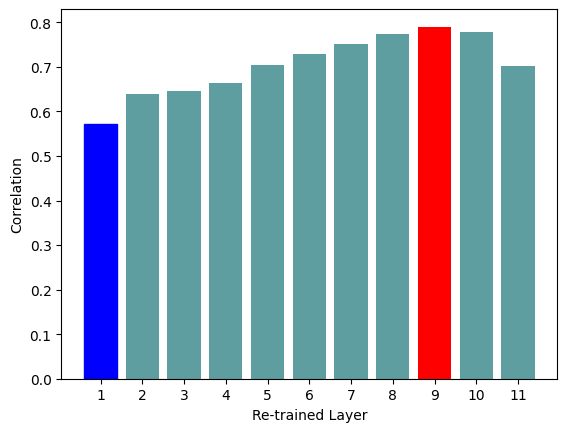

In [ ]:
import matplotlib.pyplot as plt

x = np.array([i for i in range(1,12)])
y = np.array(correlations)

plt.rcdefaults()
fig, ax = plt.subplots()
bars = ax.bar(x,y, align='center', color=np.where(y == y.max(),'red','cadetblue'))
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.set_xlabel('Re-trained Layer')
ax.set_ylabel('Correlation')
#ax.set_title("Correlations of neural networks re-trained on each layer", fontweight='bold', fontsize=14)
bars[0].set_color("blue")

In [ ]:
y = [0.3876784861828203, 0.5727261663618621, 0.7901681574721435]
x = ['BNN', 'TLNN1', 'TLNN9']

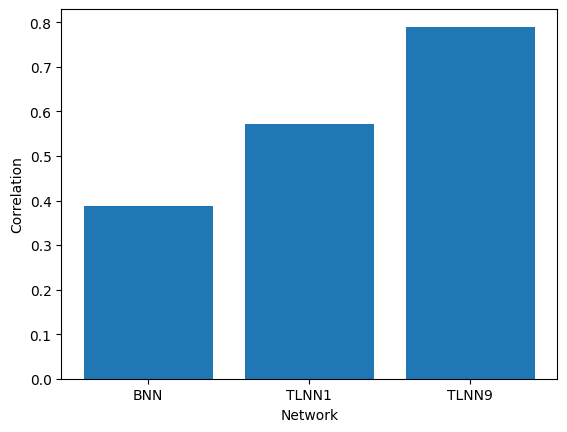

In [ ]:
import matplotlib.pyplot as plt
plt.bar(x,y)
plt.xlabel('Network')
plt.ylabel('Correlation')
plt.show()